In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

plt.rcParams.update({'font.size': 14})

In [9]:
import os

In [38]:
MSIZE = 256
SIGMA = (7.0, 7.0)

In [14]:
MATRIX_DIR = "matrices"
MUSIC_DIR = "music"
PICS_DIR = "pics"

MUSIC_MATRIX_FULL_DIR = os.path.join(MATRIX_DIR, MUSIC_DIR)
PICS_MATRIX_FULL_DIR = os.path.join(MATRIX_DIR, PICS_DIR)

MUSIC_MATRICIES = list(map(
    lambda x: os.path.join(MUSIC_MATRIX_FULL_DIR, x),
    os.listdir(MUSIC_MATRIX_FULL_DIR)
))
PICS_MATRICIES = list(map(
    lambda x: os.path.join(PICS_MATRIX_FULL_DIR, x),
    os.listdir(PICS_MATRIX_FULL_DIR)
))

MUSIC_MATRICIES[0]
PICS_MATRICIES[0]

N_MUSIC = len(MUSIC_MATRICIES)
N_PICS  = len(PICS_MATRICIES)


In [30]:
# %%timeit -r 5 -n 5 
music_mat = np.zeros((N_MUSIC, MSIZE, MSIZE))
for i, mat in enumerate(MUSIC_MATRICIES):
    music_mat[i] = np.fromfile(mat, dtype=np.uint32).reshape((MSIZE, MSIZE))
#     res_matrix = gaussian_filter(
#         tmp_mat,
#         SIGMA,
#         mode="constant",
#         cval=tmp_mat.mean()
#     )

music_mat.mean(axis=0)

array([[221295.69770115,  10051.5954023 ,   6488.42988506, ...,
          4579.49770115,   5704.40114943,   9841.89425287],
       [ 13623.24942529,   2370.13333333,   2267.85057471, ...,
          2216.55172414,   2272.69425287,   2384.18850575],
       [  8917.62758621,   2298.00114943,   2200.20574713, ...,
          2147.70804598,   2199.40804598,   2313.64712644],
       ...,
       [  2325.28735632,   2201.31149425,   2147.83678161, ...,
          2197.07701149,   2301.77586207,   7530.99310345],
       [  2426.70574713,   2273.91034483,   2216.47011494, ...,
          2274.02758621,   2378.67011494,   9667.71724138],
       [  9482.30804598,   5861.64942529,   4682.04597701, ...,
          5232.30344828,   6318.71609195,  22497.54482759]],
      shape=(256, 256))

In [33]:
# %%timeit -r 5 -n 5 
pics_mat = np.zeros((N_PICS, MSIZE, MSIZE))
for i, mat in enumerate(PICS_MATRICIES):
    pics_mat[i] = np.fromfile(mat, dtype=np.uint32).reshape((MSIZE, MSIZE))
#     res_matrix = gaussian_filter(
#         tmp_mat,
#         SIGMA,
#         mode="constant",
#         cval=tmp_mat.mean()
#     )

pics_mat.mean(axis=0)

array([[1.23296583e+03, 7.93731932e+01, 4.76254928e+01, ...,
        1.46084100e+01, 1.32194481e+01, 1.93653088e+01],
       [6.99461235e+01, 4.65965834e+01, 1.61892247e+01, ...,
        7.91064389e+00, 1.07306176e+01, 1.30893561e+01],
       [3.59632063e+01, 1.83626807e+01, 2.77266754e+01, ...,
        4.91458607e+00, 5.94086728e+00, 6.74770039e+00],
       ...,
       [4.78712221e+00, 4.60972405e+00, 3.38107753e+00, ...,
        6.82522996e+00, 5.40998686e+00, 8.40341656e+00],
       [4.29566360e+00, 4.30749014e+00, 4.32982917e+00, ...,
        9.94480946e+00, 5.50065703e+00, 6.52431012e+00],
       [2.33636399e+03, 1.44546649e-02, 1.70827858e-02, ...,
        9.19842313e-03, 1.93166886e-01, 2.87595269e+01]], shape=(256, 256))

In [50]:
tmp_mat = pics_mat.mean(axis=0)
res_matrix = gaussian_filter(
    tmp_mat,
    SIGMA,
    mode="constant",
    cval=tmp_mat.mean()
)

<Axes: title={'center': 'JPG-heatmap'}>

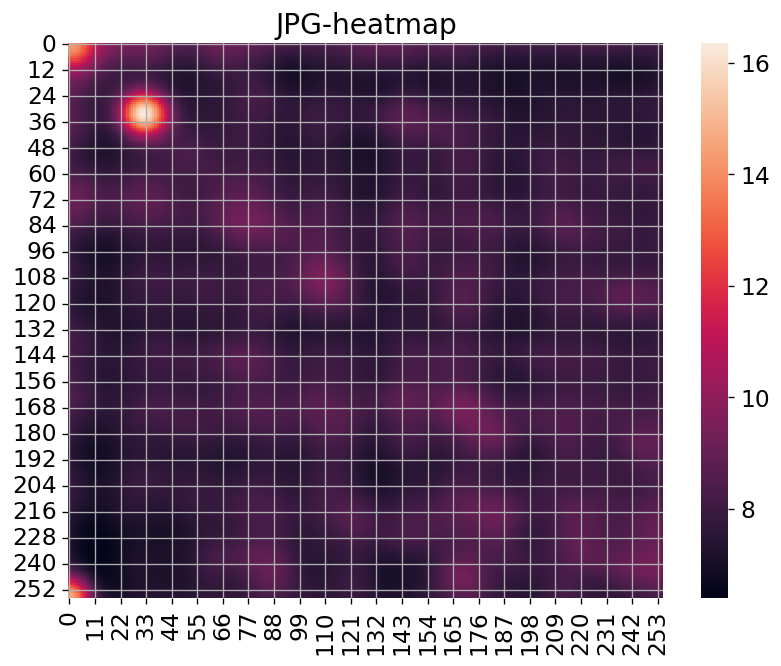

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi=120)
ax.grid()
# ax.set_xlim(1, 70)
# ax.set(xlabel='common xlabel', ylabel='common ylabel')
ax.set(title = "JPG-heatmap")

sns.heatmap(data=res_matrix)

In [52]:
tmp_mat = music_mat.mean(axis=0)
res_matrix = gaussian_filter(
    tmp_mat,
    SIGMA,
    mode="constant",
    cval=tmp_mat.mean()
)

<Axes: title={'center': 'WAV-heatmap'}>

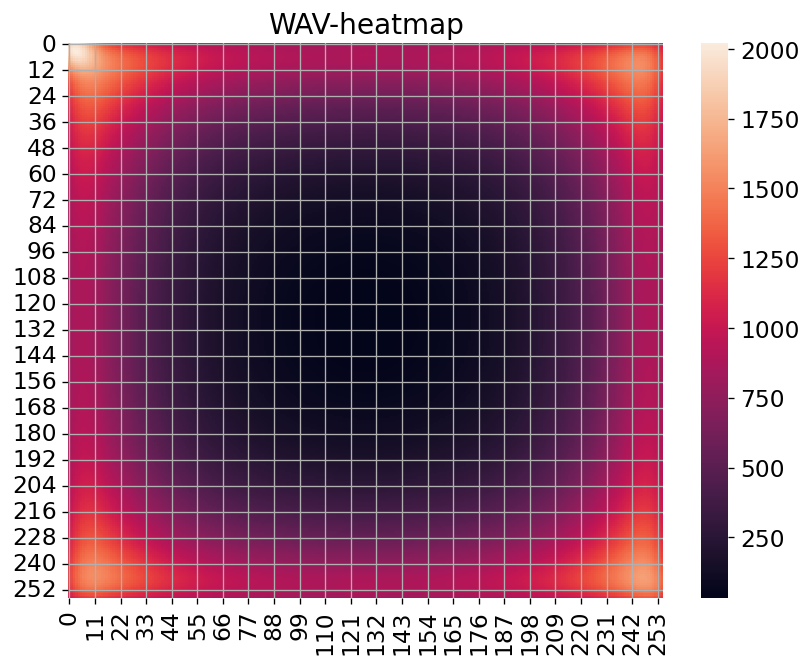

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi=120)
ax.grid()
# ax.set_xlim(1, 70)
# ax.set(xlabel='common xlabel', ylabel='common ylabel')
ax.set(title = "WAV-heatmap")

sns.heatmap(data=res_matrix)

In [ ]:
test = np.fromfile("res1.bin", dtype=np.uint32).reshape((MSIZE, MSIZE))

np.all(np.equal(matrix, test))